# Imports

In [1]:
!pip install patchify

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.windows import from_bounds
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import numpy as np
from patchify import patchify
import torch
from torch.nn import DataParallel
from torch.functional import F
from torch import nn
from torch.utils.data import DataLoader
from shapely.geometry import box
from torchvision import transforms
import time
import random

from pytorch_segmentation.data.rwanda_dataset import RwandaDataset
from pytorch_segmentation.data.inmemory_dataset import InMemorySatDataset
from pytorch_segmentation.train_net import train
from pytorch_segmentation.models import UNet
from pytorch_segmentation.losses.dice import DiceLoss
from pytorch_segmentation.losses.tversky import TverskyLoss
import pytorch_segmentation.augmentation.transforms as seg_transforms

seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [3]:

data_path = "/home/jovyan/work/satellite_data/tmp/2018.vrt"
#label_path = "data/label_masks/train"
label_path = "data/label_masks/v2"
#test_label_path = "data/label_masks/test"
tensorboard_path = "/home/jovyan/work/runs"

patch_size = [321,321,3]# [x,y,bands]
test_patch_size = [256,256,3]
overlap = 192
overlap_sa = 128
padding = False#True

val_ratio = 0.5

epochs = 300#25

early_stopping = 100

scheduler_warmup=0
sched_step = 30
sched_gamma = 0.3

#batch_size = 200
#batch_size = 50
batch_size = 50 #75

lr = 1e-4
weight_decay = 1e-3

metric = "iou"

nworkers = 4
pin_memory = True

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

save_dir = "saved_models"

transform = seg_transforms.Compose([
    seg_transforms.RandomRotation(17),
    seg_transforms.RandomHorizontalFlip(0.5),
    seg_transforms.RandomVerticalFlip(0.5),
    seg_transforms.CenterCrop(256),
    #seg_transforms.Normalize(mean=[0.5492, 0.5190, 0.4393],
#                                          std=[0.1381, 0.1320, 0.1349]) #for padded
    seg_transforms.ColorJitter(brightness=0.3,contrast=0.3,saturation=0.1)
])

test_transform = None
#test_transform = seg_transforms.Normalize(mean=[0.5492, 0.5190, 0.4393],
#                                          std=[0.1381, 0.1320, 0.1349])


# 1.1 Data Collection

In [5]:
dataset_sa = InMemorySatDataset(data_file_path=data_path,mask_path=label_path,
                             overlap=overlap_sa,patch_size=test_patch_size,padding=padding,transform=None)
print(len(dataset_sa))

3849


In [6]:
transform_sa = seg_transforms.Compose([
    seg_transforms.RandomHorizontalFlip(0.5),
    seg_transforms.RandomVerticalFlip(0.5),
    #seg_transforms.Normalize(mean=[0.5492, 0.5190, 0.4393],
#                                          std=[0.1381, 0.1320, 0.1349]) #for padded
    seg_transforms.ColorJitter(brightness=0.3,contrast=0.3,saturation=0.1)
])

train_sa, test_sa = dataset_sa.get_train_test_set(val_ratio,train_transform=transform_sa,
                                                       test_transform=test_transform)
print("Len Train: ",len(train_sa))
print("Len Test: ",len(test_sa))

Len Train:  1924
Len Test:  1925


# 1.3 Data Preparation for Training

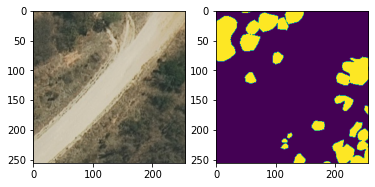

In [7]:
dataset_sa.show_tuple(0)

# 2. Model Training


#### Create Training and Test Dataset

In [8]:
train_path = None#"data/rwanda/images/train_dataset.pkl"
# test_path = "data/rwanda/images/test_dataset.pkl"
# train_data_path = "data/rwanda/images/train"
# test_data_path = "data/rwanda/images/test"
train_data_path = "data/rwanda/V2/Training_Images_RGB_v2"

In [9]:
train_dataset_rw = RwandaDataset(dataset_path=train_path,data_file_path=train_data_path,
                   shape_path="data/rwanda/V2/Training_tree_polygons_v2/training_data_polygons_model_29_v2.shp",
                             overlap=overlap,patch_size=patch_size,padding=False,transform=transform)
# train_dataset_rw.save(train_path)
# test_dataset_rw = RwandaDataset(dataset_path=test_path,data_file_path=test_data_path,
#                    shape_path="data/rwanda/Training_tree_polygons/training_data_polygons_model_29.shp",
#                              overlap=64,patch_size=patch_size,padding=False,transform=test_transform)
# test_dataset_rw.save(test_path)
print("Size Train dataset: ",len(train_dataset_rw))
#print("Size Test dataset: ",len(test_dataset_rw))

 93%|█████████▎| 100/108 [01:09<00:17,  2.13s/it]

Shape data/rwanda/V2/Training_Images_RGB_v2/image_29_4ESE1R.tif.tif is too small for patch size with size: (3, 258, 451)


100%|██████████| 108/108 [01:17<00:00,  1.39it/s]


Size Train dataset:  10701


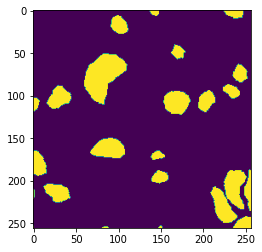

In [10]:
train_dataset_rw.get_mask(1710)

In [11]:
train_dataset = torch.utils.data.ConcatDataset([train_dataset_rw, dataset_sa])

In [12]:
# rwanda_path = "data/rwanda/rwanda.pkl"
# rwanda_dataset = RwandaDataset(dataset_path=rwanda_path,data_file_path="data/rwanda/Training_Images_RGB",
#                    shape_path="data/rwanda/Training_tree_polygons/training_data_polygons_model_29.shp",
#                              overlap=64,patch_size=patch_size,padding=False,transform=test_transform)
# train_rw,test_rw = rwanda_dataset.get_train_test_set(val_ratio,train_transform=transform,
#                                                       test_transform=test_transform)

In [13]:
# train_sa,test_sa = dataset.get_train_test_set(val_ratio,train_transform=transform,
#                                                       test_transform=test_transform)
# #train_dataset = dataset
# # test_sa = InMemorySatDataset(data_path,test_label_path,patch_size=patch_size,
# #                                   overlap=64,padding=False,
# #                                   transform=test_transform)

# train_dataset = torch.utils.data.ConcatDataset([train_dataset_rw, dataset_sa])
# print("Size Train dataset: ",len(train_dataset))

In [14]:
# train_dl = DataLoader(train_dataset,batch_size=batch_size,num_workers=nworkers,shuffle=True,pin_memory=pin_memory,
#                      drop_last=True)
# #val_dl = DataLoader(val_dataset,batch_size=batch_size,num_workers=nworkers,shuffle=False)
# test_dl = DataLoader(test_dataset,batch_size=batch_size,num_workers=nworkers,pin_memory=pin_memory,drop_last=True)

In [15]:
train_dl =DataLoader(train_dataset,batch_size=batch_size,num_workers=nworkers,shuffle=True,pin_memory=pin_memory,
                      drop_last=True)
test_dl = DataLoader(test_sa,batch_size=batch_size,num_workers=nworkers,pin_memory=pin_memory,drop_last=False)

## 2.2 Advanced Unet 
https://github.com/milesial/Pytorch-UNet

In [ ]:
model_path = save_dir+"/unet_"+str(time.strftime("%d_%m_%Y_%H%M%S"))
# Change here to adapt to your data
# n_channels=3 for RGB images 
# n_classes is the number of probabilities you want to get per pixel
net = UNet(n_channels=3, n_classes=2, bilinear=False)
#net= DataParallel(net)

net = net.to(device=device)


In [17]:
#weights = len(train_dataset.y.view(-1)) /2*np.bincount(train_dataset.y.view(-1))
#class_weights  = torch.tensor(1-weights/ np.sum(weights),dtype=torch.float32).to(device)
#loss_fn = nn.CrossEntropyLoss(weight=class_weights)

loss_fn = TverskyLoss(0.3,0.7) #nn.CrossEntropyLoss() #TverskyLoss(0.3,0.7)
opt = torch.optim.Adam(net.parameters(),lr=lr)
#opt = torch.optim.AdamW(net.parameters(),lr=lr,weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(opt, sched_step,gamma=sched_gamma)
#scheduler = None

In [18]:
#from pytorch_segmentation.losses.tversky import TverskyLoss
#loss_fn = TverskyLoss(0.8,0.1)

In [ ]:
train_loss,valid_loss = train(net,train_dl,test_dl,loss_fn,opt,epochs,model_path=model_path+".pth",scheduler=scheduler,
                              scheduler_warmup=scheduler_warmup,early_stopping=early_stopping,
                              metric=metric,tensorboard_path=tensorboard_path,nimgs=4,figsize=(16,14),device=device,seed=seed)

INFO: Start run for unet_16_05_2022_080327!
Epoch 0/299
----------


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 0.2244 iou: 0.4076097173123425


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid Loss: 0.0844 iou: 0.8405194530239353
Epoch 1/299
----------


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train Loss: 0.1346 iou: 0.4755513294251104


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid Loss: 0.0533 iou: 0.8409708955071189
Epoch 2/299
----------


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train Loss: 0.1056 iou: 0.488727545820151


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid Loss: 0.0342 iou: 0.8474115628700751
Epoch 3/299
----------


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train Loss: 0.0908 iou: 0.5138014501722408


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid Loss: 0.0260 iou: 0.8555389178263677
Epoch 4/299
----------


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train Loss: 0.0818 iou: 0.5230060368264254


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid Loss: 0.0231 iou: 0.8578704665233563
Epoch 5/299
----------


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train Loss: 0.0757 iou: 0.5357312187296418


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid Loss: 0.0216 iou: 0.8460540949524223
Epoch 6/299
----------


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train Loss: 0.0712 iou: 0.5451574984080193


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid Loss: 0.0170 iou: 0.86523498730226
Epoch 7/299
----------


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train Loss: 0.0671 iou: 0.5573827658117432


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid Loss: 0.0175 iou: 0.8560601070329741
Epoch 8/299
----------


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train Loss: 0.0634 iou: 0.5576534591794423


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid Loss: 0.0154 iou: 0.8653228414523138
Epoch 9/299
----------


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train Loss: 0.0614 iou: 0.5634479676325297


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid Loss: 0.0146 iou: 0.8642161519496472
Epoch 10/299
----------


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train Loss: 0.0593 iou: 0.5713457152810703


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid Loss: 0.0145 iou: 0.8715952000060638
Epoch 11/299
----------


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train Loss: 0.0580 iou: 0.5732604475160644


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid Loss: 0.0156 iou: 0.8749284217884015
Epoch 12/299
----------


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train Loss: 0.0558 iou: 0.5807668236932394


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid Loss: 0.0131 iou: 0.8803755834505156
Epoch 13/299
----------


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train Loss: 0.0547 iou: 0.579189645977774


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid Loss: 0.0156 iou: 0.8477815474782672
Epoch 14/299
----------


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train Loss: 0.0533 iou: 0.5818823938517227


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid Loss: 0.0121 iou: 0.8821978243914518
Epoch 15/299
----------


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train Loss: 0.0522 iou: 0.5857696415427625


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid Loss: 0.0119 iou: 0.8783426633128872
Epoch 16/299
----------


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train Loss: 0.0514 iou: 0.5866218655789431


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid Loss: 0.0121 iou: 0.8701080819229027
Epoch 17/299
----------


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train Loss: 0.0509 iou: 0.5916447098722163


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid Loss: 0.0115 iou: 0.892441328469809
Epoch 18/299
----------


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


## 2.3 DeepLabV3

In [12]:
from torchvision import models
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
lr = 1e-4

model_path = save_dir+"/deeplabv3_"+str(time.strftime("%d_%m_%Y_%H%M%S"))
net = models.segmentation.deeplabv3_resnet50(pretrained=False,
                                          progress=False) #also Resnet101

net.classifier = DeepLabHead(2048, 2)

net = net.to(device)



In [13]:
weights = len(train_dataset.y.view(-1)) /2*np.bincount(train_dataset.y.view(-1))
class_weights  = torch.tensor(1-weights/ np.sum(weights),dtype=torch.float32).to(device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

#loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(net.parameters(),lr=lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.9)

In [14]:
def iou_score(y_pred,target,absent_score=1.0):
    numerator = torch.sum(y_pred * target)  # TP
    denominator = torch.sum(y_pred + target) - numerator  # 2TP + FP + FN - TP
    print(numerator)
    print(denominator)
    iou = (numerator) / (denominator)
    iou[denominator == 0] = absent_score
    return iou

In [14]:
train_loss,valid_loss = train(net,train_dl,val_dl,loss_fn,opt,epochs,tensorboard_path=tensorboard_path,
                              model_path=model_path,deeplab=True,scheduler=scheduler,
                              device=device,seed=seed)

Epoch 0/24
----------


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 0.3521 iou: 0.18477384620928206
valid Loss: 0.2017 iou: 0.21640455397692593
Epoch 1/24
----------
train Loss: 0.1943 iou: 0.28051325218244033
valid Loss: 0.1414 iou: 0.2448799813335592
Epoch 2/24
----------
train Loss: 0.1797 iou: 0.26320808103985405
valid Loss: 0.1030 iou: 0.33399442542682994
Epoch 3/24
----------
train Loss: 0.1306 iou: 0.2934116027571938
valid Loss: 0.1004 iou: 0.3169833681800149
Epoch 4/24
----------
train Loss: 0.0977 iou: 0.32801382927732037
valid Loss: 0.0942 iou: 0.3110184306448156
Epoch 5/24
----------
train Loss: 0.0824 iou: 0.3726451350884004
valid Loss: 0.0827 iou: 0.3070678559216586
Epoch 6/24
----------
train Loss: 0.0760 iou: 0.38149649538523095
valid Loss: 0.0738 iou: 0.3369134561582045
Epoch 7/24
----------
train Loss: 0.0765 iou: 0.38676539611029015
valid Loss: 0.0731 iou: 0.36030894192782315
Epoch 8/24
----------
train Loss: 0.0697 iou: 0.34991152801296926
valid Loss: 0.0764 iou: 0.31252685622735454
Epoch 9/24
----------
train Loss: 0.063

## 3 Validation

In [11]:
net.eval()
output = []
y_test = []
for i,batch in enumerate(test_dl):
    x = batch["x"].to(device)
    out = net(x)#["out"]
    #out = F.softmax(out,dim=1)
    out = torch.argmax(out,dim=1)
    out = out.cpu().numpy()
    output.append(out)
    y_test.extend(batch["y"].numpy())
imgs = torch.as_tensor(np.vstack(output))
y_test = torch.as_tensor(np.array(y_test))

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


In [12]:
def iou(preds,target,absent_score=0.0):
    numerator = torch.sum(preds * target)  # TP
    denominator = torch.sum(preds + target) - numerator  # 2TP + FP + FN - TP
    iou = (numerator) / (denominator)
    iou[denominator == 0] = absent_score
    return iou.item()

def dice_coeff(preds, target):
    # F1 = TP / (TP + 0.5 (FP + FN)) = 2TP / (2TP + FP + FN)
    numerator = 2 * torch.sum(preds * target)  # 2TP
    denominator = torch.sum(preds + target)  # 2TP + FP + FN
    if (denominator == 0):
        return torch.tensor(0.).to(preds.device)
    return ((numerator) / (denominator)).item()



In [13]:
import pandas as pd
from sklearn.metrics import f1_score,accuracy_score
iou_score = iou(imgs,y_test)
dice_score = dice_coeff(imgs,y_test)
acc = accuracy_score(imgs.numpy().reshape(-1),y_test.numpy().reshape(-1))
f1 = f1_score(imgs.numpy().reshape(-1),y_test.numpy().reshape(-1))
#accuracy = accuracy(imgs,test_dataset.y)
print(f"IoU: ",iou_score)
print("Dice score: ",dice_score)
print("F1 score: ",f1)
print("Accuracy: ",acc)
#print("Pixel accuracy: ",dice_score)
df = pd.DataFrame([{**{"model_name":model_path,"IoU":iou_score,"dice_score":dice_score,
                       "Accuracy":acc,"F1":f1},**test_dataset.get_config()}])
df.to_csv(model_path+"_score.csv")

IoU:  0.6320269107818604
Dice score:  0.7745299935340881
F1 score:  0.7745299893548476
Accuracy:  0.9454810430133154


AttributeError: 'ConcatDataset' object has no attribute 'get_config'

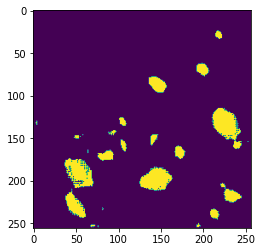

<AxesSubplot:>

In [ ]:
show(imgs[2].numpy())

In [ ]:
test_dataset.get_mask(2)

AttributeError: 'ConcatDataset' object has no attribute 'get_mask'

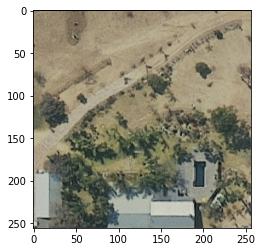

In [18]:
test_dataset.get_img(2)

# Backlog

541


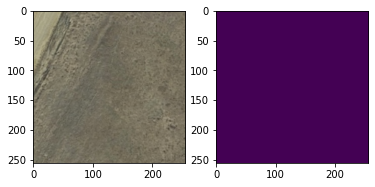

259


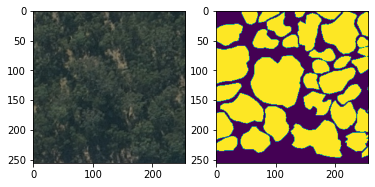

43


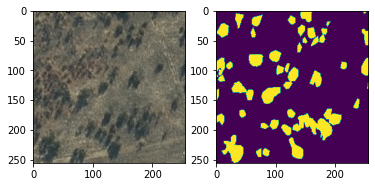

1005


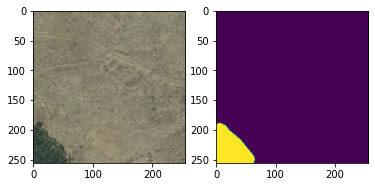

584


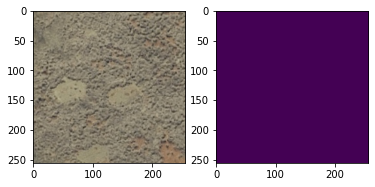

310


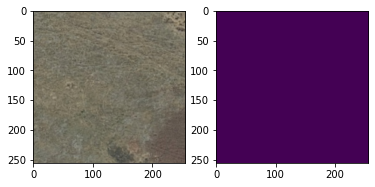

657


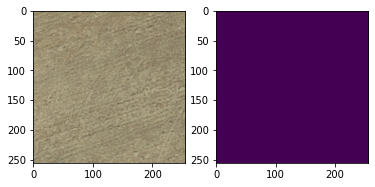

1209


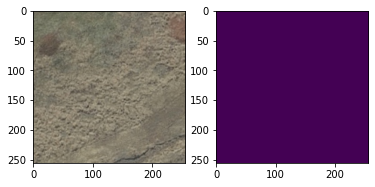

210


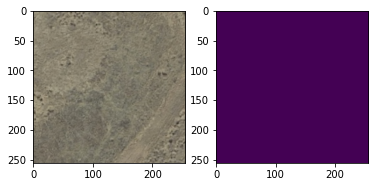

155


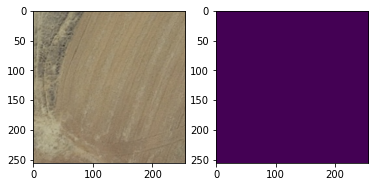

558


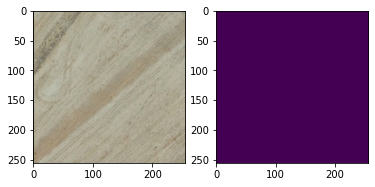

411


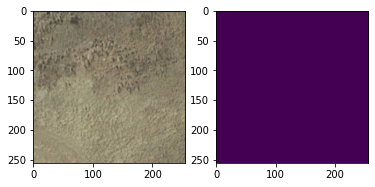

1004


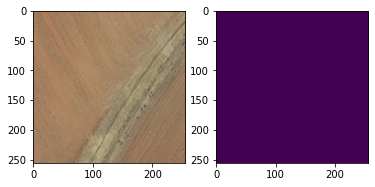

493


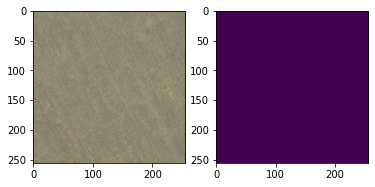

1065


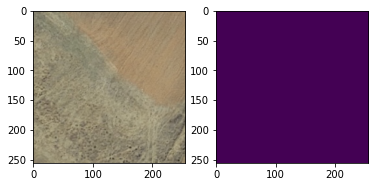

522


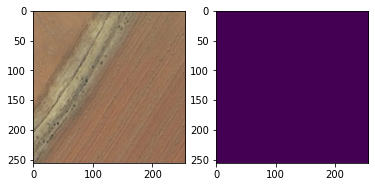

543


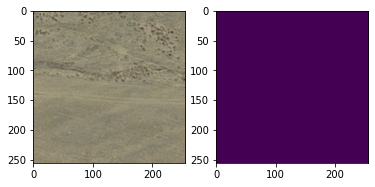

551


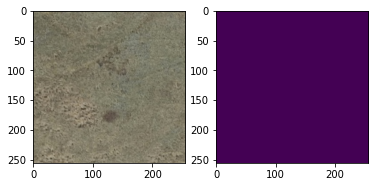

428


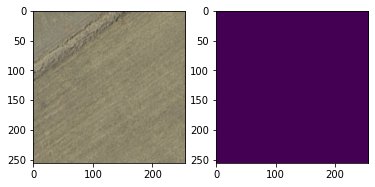

422


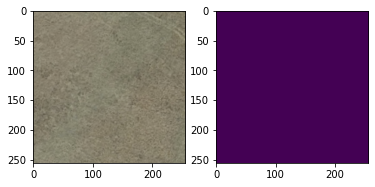

739


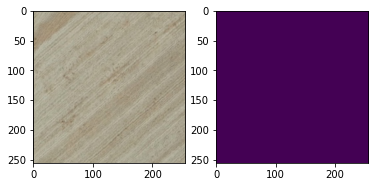

458


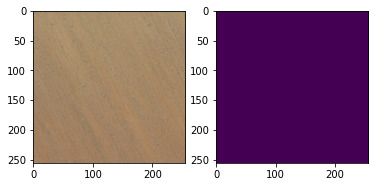

1146


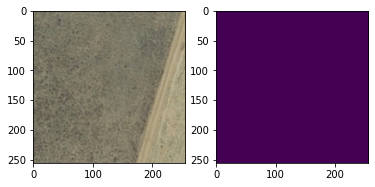

423


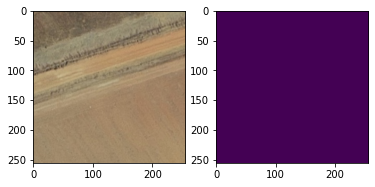

298


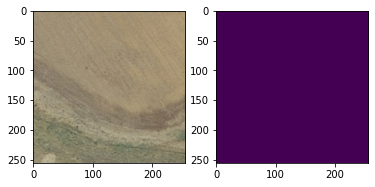

1027


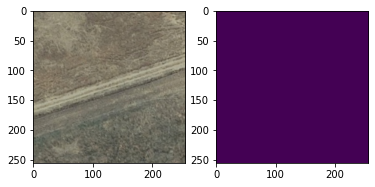

350


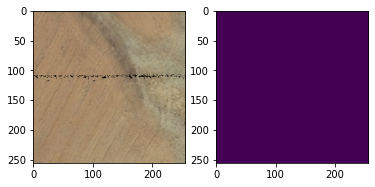

652


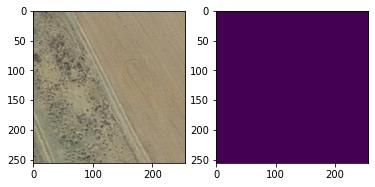

1208


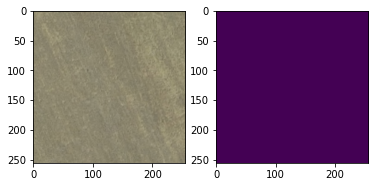

1207


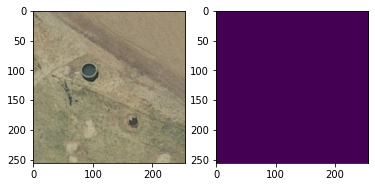

In [28]:
plt.figure()

for i in np.random.choice(range(len(train_dataset)),size=30,replace=False):
    print(i)
    plt.subplot(121)
    plt.imshow(train_dataset[i]["x"].permute(1, 2, 0).numpy())
    plt.subplot(122)
    plt.imshow(train_dataset[i]["y"].numpy())
    plt.show()

In [67]:
net = net
out = net(train_dataset[654]["x"].unsqueeze(0).to(device))

In [68]:
img = F.softmax(out,dim=1)
img = torch.argmax(img,dim=1)
img = img.cpu().numpy()


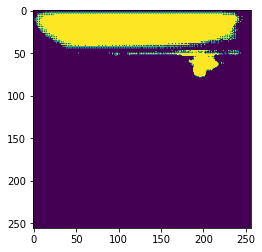

<AxesSubplot:>

In [69]:
show(img)

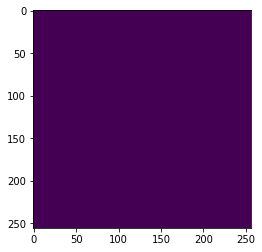

In [70]:
train_dataset.get_mask(654)

## 2.1. Simple Unet
https://medium.com/analytics-vidhya/creating-a-very-simple-u-net-model-with-pytorch-for-semantic-segmentation-of-satellite-images-223aa216e705

In [22]:
from pytorch_segmentation.models.unet_simple import UNet
from pytorch_segmentation.train_net import train
import time


In [23]:
net = UNet(3,2)
net = net.to(device)


In [24]:
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(net.parameters(),lr=lr)
train_loss,valid_loss = train(net,train_dl,val_dl,loss_fn,opt,epochs,device,seed)
torch.save(net.state_dict(), save_dir+"/unet_simple"+str(time.strftime("%d_%m_%Y_%H%M%S"))+".pth")

Epoch 0/24
----------
train Loss: 0.6902 iou: 0.02955839559965005



KeyboardInterrupt

